## Movie review tagging model training - Data Science

### Data preparation

#### Preprocessed dataset reading

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/Preprocessed_Dataset.csv')
df.head()

,Reviews,Acting,Plot,Scene,Comedy,Touching,Preprocessed Reviews
0,Xem buồn ngủ lắm 1. nội dung k có gì đặc sắc 2...,1,1,1,0,0,xem buồn_ngủ 1 nội_dung không đặc_sắc 2 hình_ả...
1,"Phim hay, coi cuốn từ đầu tới cuối nha. Phim c...",0,1,1,1,0,phim hay coi cuốn từ đầu tới cuối phim nhiều ý...
2,Nhiều sr fim giống nên xem hơi nhàm,0,0,0,0,0,nhiều mùa phim giống xem hơi nhàm
3,"Phim đáng xem, xứng danh bom tấn. Các cảnh qua...",1,0,1,0,0,phim đáng xem xứng danh bom tấn các cảnh quay ...
4,"Cài cắm nhiều nút thắt “đòn bẫy” xuyên suốt, t...",0,1,0,0,0,cài cắm nhiều nút thắt đòn bẫy xuyên suốt tác_...


In [2]:
copied_df = df.copy()
copied_df = copied_df.reset_index(drop=True)
copied_df = copied_df.astype(str)

copied_df['Acting'] = copied_df['Acting'].astype(float)
copied_df['Plot'] = copied_df['Plot'].astype(float)
copied_df['Scene'] = copied_df['Scene'].astype(float)
copied_df['Comedy'] = copied_df['Comedy'].astype(float)
copied_df['Touching'] = copied_df['Touching'].astype(float)

copied_df.dtypes

Reviews                  object
Acting                  float64
Plot                    float64
Scene                   float64
Comedy                  float64
Touching                float64
Preprocessed Reviews     object
dtype: object

#### Data overall visulization

In [3]:
import matplotlib.pyplot as plt

sum_series = copied_df[['Acting', 'Plot', 'Scene', 'Comedy', 'Touching']].sum()

tags = sum_series.index.tolist()
counts = sum_series.values.tolist()

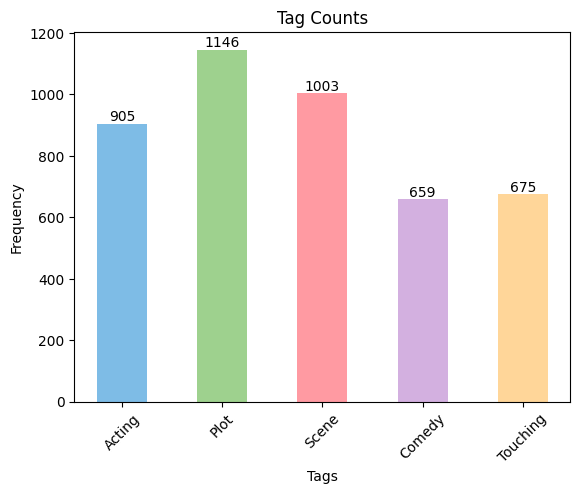

In [4]:
colors = ['#7ebce6', '#9ed18e', '#ff9aa2', '#d3b0e0', '#ffd699']

bars = plt.bar(tags, counts,width=0.5, color=colors)

for bar, count in zip(bars, counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height(), 
        str(int(count)),
        ha = 'center',   
        va = 'bottom'
    )

plt.xticks(rotation=45)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Tag Counts')
plt.show()

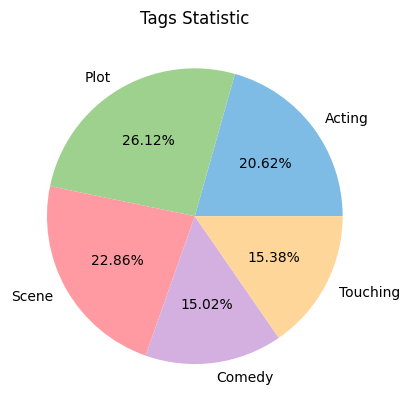

Acting       905.0
Plot        1146.0
Scene       1003.0
Comedy       659.0
Touching     675.0
dtype: float64


In [5]:
plt.figure()
plt.pie(
    counts, 
    labels=tags, 
    colors=colors, 
    autopct='%1.2f%%'
)

plt.title('Tags Statistic')
plt.show()

print(sum_series)

#### Data vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=2, max_df=0.8)

corpus = copied_df['Preprocessed Reviews']
X_features = tfidf.fit_transform(corpus).toarray()

#### Data split

In [7]:
from sklearn.model_selection import train_test_split

y = copied_df[['Acting', 'Plot', 'Scene', 'Comedy', 'Touching']]

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(4423, 1000)
(4423, 5)
(1106, 1000)
(1106, 5)


(None, None)

### Model Training

In [8]:
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

best_model_method = None
best_model_params = {}
best_model_f1_score = 0

#### Using BinaryRelevance method

The `BinaryRelevance` method is an approach used in multi-label classification problems, where each instance can belong to multiple classes (labels) simultaneously. It transforms a multi-label problem into multiple independent binary classification problems, one for each label.

How It Works:
- For each label, `Binary Relevance` creates a separate binary classification problem.
- Each classifier predicts whether or not a particular label applies to a given instance, treating each label as independent from the others.
- The final prediction is a combination of all individual binary classifiers’ predictions.

Advantages:
- Simple to implement.
- Works well when the labels are independent of each other.

Limitations:
- Label independence assumption: It assumes that labels are independent, which might not be the case in real-world datasets (some labels might be correlated).
- Requires training multiple classifiers, which can increase computational cost.

In [9]:
from skmultilearn.problem_transform import BinaryRelevance

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0, 1.3],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [50, 100, 150],
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5, 8, 9],
        'classifier__weights': ['uniform', 'distance'],
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.01, 0.1, 1.0],
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    },
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.01, 0.1, 1.0],
        'classifier__max_iter': [50, 100, 200],
    }
]

scores = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
clf = GridSearchCV(BinaryRelevance(), parameters, scoring=scores, refit=False)
clf.fit(X_train, y_train)

print('\nAccuracy for each parameter set:')
for i in range(len(clf.cv_results_['params'])):
    for scorer in scores:
        mean_score = clf.cv_results_[f'mean_test_{scorer}'][i]
        print(f'Parameter set {i+1}: {clf.cv_results_["params"][i]} - Mean {scorer}: {mean_score}')
    print('\n')

c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Accuracy for each parameter set:
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean f1_micro: 0.47083934748126877
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean f1_macro: 0.45532114753477815
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean precision_micro: 0.862909647658879
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean precision_macro: 0.8837114802533176
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean recall_micro: 0.32420354813801394
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean recall_macro: 0.313834857574704


Parameter set 2: {'classifier': MultinomialNB(), 'classifier__alpha': 1.0} - Mean f1_micro: 0.4376328721488988
Parameter set 2: {'classifier': MultinomialNB(), 'classifier__alpha': 1.0} - Mean f1_macro: 0.41989514202333933
Parameter set 2: {'classifier': MultinomialNB(), 'cl

In [10]:
# Display the best parameter and create the best model
best_score_idx = clf.cv_results_['mean_test_f1_micro'].argmax()
best_params = {k.replace('classifier__', ''): v for k, v in clf.cv_results_['params'][best_score_idx].items()}
print(f'Best parameters: {best_params}')

f1_micro_score = clf.cv_results_['mean_test_f1_micro'][best_score_idx]
print('Mean f1_micro score:', f1_micro_score)

if f1_micro_score > best_model_f1_score:
    best_model_method = 'BinaryRelevance'
    best_model_params = best_params
    best_model_f1_score = f1_micro_score

Best parameters: {'classifier': RandomForestClassifier(), 'criterion': 'gini', 'n_estimators': 100}
Mean f1_micro score: 0.7471174861319809


#### Using LabelPowerset method

The `Label Powerset` method is another popular approach used in multi-label classification. Unlike `Binary Relevance`, which treats each label as independent, `Label Powerset` considers the combinations of labels and treats each unique set of labels as a single label in a multi-class classification problem.

How It Works:
- The idea behind `Label Powerset` is to transform the multi-label classification problem into a single-label multi-class classification problem.
- Each unique combination of labels in the dataset is treated as a separate class.
- A single classifier is trained on these unique label combinations.

Advantages:
- Considers label dependencies: By treating label combinations as classes, it captures the relationships between labels.
- Can perform well in cases where certain label combinations are frequent and meaningful.

Limitations:
- Scalability: If there are many possible combinations of labels, the number of classes grows exponentially, which can make the problem very large and computationally expensive.
- Rare combinations: Some combinations of labels might occur very infrequently, which can make the model struggle to generalize to new instances with rare combinations.

In [11]:
from skmultilearn.problem_transform import LabelPowerset

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0, 1.3],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [50, 100, 150],
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5, 8, 9],
        'classifier__weights': ['uniform', 'distance'],
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.01, 0.1, 1.0],
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    },
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.01, 0.1, 1.0],
        'classifier__max_iter': [50, 100, 200],
    }
]

scores = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
clf = GridSearchCV(LabelPowerset(), parameters, scoring=scores, refit=False)
clf.fit(X_train, y_train)

print('\nAccuracy for each parameter set:')
for i in range(len(clf.cv_results_['params'])):
    for scorer in scores:
        mean_score = clf.cv_results_[f'mean_test_{scorer}'][i]
        print(f'Parameter set {i+1}: {clf.cv_results_["params"][i]} - Mean {scorer}: {mean_score}')
    print('\n')

c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Accuracy for each parameter set:
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean f1_micro: 0.362284447348622
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean f1_macro: 0.35249442471219783
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean precision_micro: 0.8571568386985173
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean precision_macro: 0.8785269074059112
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean recall_micro: 0.22980934105459694
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean recall_macro: 0.22355462909421844


Parameter set 2: {'classifier': MultinomialNB(), 'classifier__alpha': 1.0} - Mean f1_micro: 0.30067806203930675
Parameter set 2: {'classifier': MultinomialNB(), 'classifier__alpha': 1.0} - Mean f1_macro: 0.29239547556837014
Parameter set 2: {'classifier': MultinomialNB(), '

In [12]:
# Display the best parameter and create the best model
best_score_idx = clf.cv_results_['mean_test_f1_micro'].argmax()
best_params = {k.replace('classifier__', ''): v for k, v in clf.cv_results_['params'][best_score_idx].items()}
print(f'Best parameters: {best_params}')

f1_micro_score = clf.cv_results_['mean_test_f1_micro'][best_score_idx]
print('Mean f1_micro score:', f1_micro_score)

if f1_micro_score > best_model_f1_score:
    best_model_method = 'LabelPowerset'
    best_model_params = best_params
    best_model_f1_score = f1_micro_score

Best parameters: {'classifier': RandomForestClassifier(), 'criterion': 'gini', 'n_estimators': 150}
Mean f1_micro score: 0.6188941037093812


#### Using Classifier Chain method

The `Classifier Chain` is another advanced method used in multi-label classification. It combines the ideas of `Binary Relevance` and `Label Powerset`, capturing both the individual label characteristics and the dependencies between labels.

How It Works:
- `Classifier Chain` transforms the multi-label classification problem into a sequence of binary classification problems.
- Each classifier in the chain predicts whether a specific label applies to an instance, using not only the input features but also the predictions of the previous classifiers in the chain.
- This allows the model to capture dependencies between labels because the prediction for a label can depend on the predictions for other labels made earlier in the chain.

Advantages:
- Captures label dependencies: Unlike Binary Relevance, which treats labels independently, Classifier Chain captures the relationships between labels by conditioning on previously predicted labels.
- Flexible and efficient: It provides a balance between simple methods like Binary Relevance and complex methods like Label Powerset.

Limitations:
- Order of labels matters: The performance of the model can be sensitive to the order in which the labels are processed in the chain. Sometimes, a suboptimal chain order may degrade the performance.
- Computational cost: Since each label prediction depends on previous ones, the process can be slower than Binary Relevance but generally faster than Label Powerset.

In [13]:
from skmultilearn.problem_transform import ClassifierChain

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0, 1.3],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [50, 100, 150],
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5, 8, 9],
        'classifier__weights': ['uniform', 'distance'],
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.01, 0.1, 1.0],
        'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    },
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.01, 0.1, 1.0],
        'classifier__max_iter': [50, 100, 200],
    }
]

scores = ['f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
clf = GridSearchCV(ClassifierChain(), parameters, scoring=scores, refit=False)
clf.fit(X_train, y_train)

print('\nAccuracy for each parameter set:')
for i in range(len(clf.cv_results_['params'])):
    for scorer in scores:
        mean_score = clf.cv_results_[f'mean_test_{scorer}'][i]
        print(f'Parameter set {i+1}: {clf.cv_results_["params"][i]} - Mean {scorer}: {mean_score}')
    print('\n')

c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TEMP.DESKTOP-NGOONGQ.001\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Accuracy for each parameter set:
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean f1_micro: 0.4768813530823889
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean f1_macro: 0.4638412958165935
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean precision_micro: 0.8678285511823004
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean precision_macro: 0.8858577776345076
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean recall_micro: 0.3292843382947178
Parameter set 1: {'classifier': MultinomialNB(), 'classifier__alpha': 0.7} - Mean recall_macro: 0.3205013972645105


Parameter set 2: {'classifier': MultinomialNB(), 'classifier__alpha': 1.0} - Mean f1_micro: 0.4457504443566539
Parameter set 2: {'classifier': MultinomialNB(), 'classifier__alpha': 1.0} - Mean f1_macro: 0.4340076838357959
Parameter set 2: {'classifier': MultinomialNB(), 'clas

In [14]:
# Display the best parameter and create the best model
best_score_idx = clf.cv_results_['mean_test_f1_micro'].argmax()
best_params = {k.replace('classifier__', ''): v for k, v in clf.cv_results_['params'][best_score_idx].items()}
print(f'Best parameters: {best_params}')

f1_micro_score = clf.cv_results_['mean_test_f1_micro'][best_score_idx]
print('Mean f1_micro score:', f1_micro_score)

if f1_micro_score > best_model_f1_score:
    best_model_method = 'ClassifierChain'
    best_model_params = best_params
    best_model_f1_score = f1_micro_score

Best parameters: {'classifier': RandomForestClassifier(), 'criterion': 'gini', 'n_estimators': 150}
Mean f1_micro score: 0.7450931733313856


#### Getting the best model and performing some predictions

In [15]:
params = {key: value for key, value in best_model_params.items() if key != 'classifier'}
BaseClassifier = best_model_params['classifier']
BaseClassifier.set_params(**params)

if best_model_method == 'BinaryRelevance':
    best_model = BinaryRelevance(BaseClassifier)
elif best_model_method == 'LabelPowerset':
    best_model = LabelPowerset(BaseClassifier)
elif best_model_method == 'ClassifierChain':
    best_model = ClassifierChain(BaseClassifier)
else:
    raise TimeoutError('Unable to find the best model')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy_value = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print(best_model)
print('Micro F1 score:', best_model_f1_score)
print('Accuracy score:', accuracy_value)
print('Hamming loss:', hamming_loss_value)

BinaryRelevance(classifier=RandomForestClassifier(), require_dense=[True, True])
Micro F1 score: 0.7471174861319809
Accuracy score: 0.7242314647377939
Hamming loss: 0.06672694394213381


### Model exportation using Joblib

In [16]:
import joblib

joblib.dump(best_model, 'Review_Tagger_Model.pkl')

['Review_Tagger_Model.pkl']
